In [1]:
import numpy as np
import pandas as pd
from keras.layers import merge, add
from keras.layers import Dense, Dropout, Activation, LSTM, Conv1D, MaxPooling1D, Flatten, AtrousConvolution1D, Input
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
## Data preparation

In [3]:
data= pd.read_csv('^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [4]:
data= data.dropna(axis=0)
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [5]:
data= data.values[:, 1:5]
print (data.shape)

(4284, 4)


In [6]:
print (data[:6, :])

[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]
 [11113.370117 11313.450195 11098.450195 11253.259766]
 [11247.05957 11528.139648 11239.919922 11522.55957]
 [11532.480469 11638.280273 11532.480469 11572.200195]]


In [7]:
y= data[1:, 3]
print (y.shape)
X= data[:4283,:]
print (X.shape)

(4283,)
(4283, 4)


In [8]:
# y= (y- min(y))/(max(y)- min(y))
print (y[4270:])
print (y[:7])

[19918.880859 19933.810547 19945.039063 19833.679688 19819.779297
 19762.599609 19881.759766 19942.160156 19899.289063 19963.800781
 19887.380859 19855.529297 19954.279297]
[10997.929688 11122.650391 11253.259766 11522.55957 11572.200195
 11511.080078 11551.099609]


In [9]:
# X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape)
print (X[:3, :])

(4283, 4)
[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]]


In [10]:
## Input layer preparation

In [11]:
time_steps= 100
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(4184, 100, 4) (4184,)


In [12]:
## split into train and test sets

In [13]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3427, 100, 4) (3427,)
(757, 100, 4) (757,)


In [14]:
# data normalisation after split the train/test

In [15]:
y_train= (y_train- min(y_train))/(max(y_train)- min(y_train))
X_train= (X_train- np.min(X_train,axis=0))/(np.max(X_train, axis=0)-np.min(X_train,axis=0))

In [16]:
y_test= (y_test- min(y_test))/(max(y_test)- min(y_test))
X_test= (X_test- np.min(X_test,axis=0))/(np.max(X_test, axis=0)-np.min(X_test,axis=0))

In [17]:
## Model fitting

In [18]:
## Model - 1 - main - with residual learning

In [19]:
x= Input(shape= (100, 4))
x_side= Conv1D(64, 1, border_mode='causal', activation='relu')(x)
pool= MaxPooling1D(pool_length=2)(x_side)
dil_conv1= AtrousConvolution1D(64, 3, atrous_rate=2, border_mode='causal', activation='relu')(x)
pool1= MaxPooling1D(pool_length=2)(dil_conv1)
# out1= merge([pool, pool1], mode= 'sum', output_shape= (50,64))
out1= add([pool, pool1])
lstm= LSTM(50, return_sequences= True)(out1)
dropout= Dropout(0.1)(lstm)
x_n= Conv1D(32, 1, border_mode='causal', activation='relu')(dropout)
pool_n= MaxPooling1D(pool_length=2)(x_n)
dil_conv2= AtrousConvolution1D(32, 3, atrous_rate=2, border_mode='causal', activation='relu')(dropout)
pool2= MaxPooling1D(pool_length=2)(dil_conv2)
# out2= merge([pool_n, pool2], mode= 'sum', output_shape= (25,32))
out2 = add([pool_n, pool2])
conv1= Conv1D(16, 3, border_mode='causal')(out2)
flat= Flatten()(conv1)
dense= Dense(output_dim=1, activation='linear')(flat)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 1, activation="relu", padding="causal")`
  
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wang/anaconda3/lib/python3.7/site-packages/keras/legacy/layers.py:290: UserWarning: The `AtrousConvolution1D` layer  has been deprecated. Use instead the `Conv1D` layer with the `dilation_rate` argument.
  warnings.warn('The `AtrousConvolution1D` layer '
/home/wang/anaconda3/lib/python3.7/site-packages/keras/legacy/layers.py:294: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, activation="relu", dilation_rate=2, padding="causal")`
  return Conv1D(*args, **kwargs)
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_lau

In [20]:
model = Model(input=x, output=dense)
# model.compile(optimizer='rmsprop',

model.summary()

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=256, nb_epoch=50, validation_data = (X_test, y_test), verbose=2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 4)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 100, 64)      320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 64)      832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 50, 64)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 3427 samples, validate on 757 samples
Epoch 1/50
 - 3s - loss: 0.0642 - acc: 2.9180e-04 - val_loss: 0.0224 - val_acc: 0.0026
Epoch 2/50
 - 1s - loss: 0.0111 - acc: 5.8360e-04 - val_loss: 0.0214 - val_acc: 0.0026
Epoch 3/50
 - 1s - loss: 0.0074 - acc: 5.8360e-04 - val_loss: 0.0175 - val_acc: 0.0026
Epoch 4/50
 - 1s - loss: 0.0056 - acc: 5.8360e-04 - val_loss: 0.0174 - val_acc: 0.0026
Epoch 5/50
 - 1s - loss: 0.0050 - acc: 5.8360e-04 - val_loss: 0.0175 - val_acc: 0.0026
Epoch 6/50
 - 1s - loss: 0.0046 - acc: 5.8360e-04 - val_loss: 0.0179 - val_acc: 0.0026
Epoch 7/50
 - 1s - loss: 0.0039 - acc: 5.8360e-04 - val_loss: 0.0176 - val_acc: 0.0026
Epoch 8/50
 - 1s - loss: 0.0035 - acc: 5.8360e-04 - val_loss: 0.0178 - val_acc: 0.0026
Epoch 9/50
 - 1s - loss: 0.0033 - acc: 5.8360e-04 - val_loss: 0.0186 - val_acc: 0.0026
Epoch 10/50
 - 1s - loss: 0.0030 - acc: 5.8360e-04 - val_loss: 0.0180 - val_acc: 0.0026
Epoch 11/50
 - 1s - loss: 0.0030 - acc: 5.8360e-04 - val_loss: 0.0181 - val_acc: 0

In [21]:
score= model.evaluate(X_test, y_test, batch_size=256)

757/757 [==============================] - 0s 67us/step


In [22]:
print (score)

[0.00477478196881367, 0.0026420078688157204]


In [23]:
y_pred= model.predict(X_test)

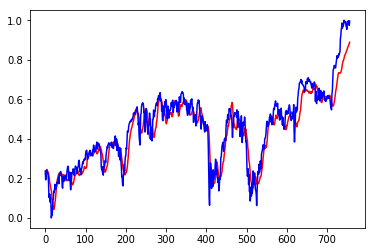

In [24]:
plt.plot(y_pred, 'r-')
plt.plot(y_test, 'b-')
plt.show()

In [25]:
## Model - 2 - simple - without residual learning

In [26]:
model = Sequential()
model.add(AtrousConvolution1D(64, 5, atrous_rate=2, border_mode='same', input_shape= (100,4)))
model.add(MaxPooling1D(pool_length=2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(AtrousConvolution1D(32, 3, atrous_rate=2, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 100, 64)           1344      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 50)            23000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 50, 32)            4832      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
__________

/home/wang/anaconda3/lib/python3.7/site-packages/keras/legacy/layers.py:294: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 5, input_shape=(100, 4), dilation_rate=2, padding="same")`
  return Conv1D(*args, **kwargs)
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wang/anaconda3/lib/python3.7/site-packages/keras/legacy/layers.py:294: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, dilation_rate=2, padding="same")`
  return Conv1D(*args, **kwargs)
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  import sys
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call t

In [27]:
# model.compile(loss='mse', optimizer='adagrad', metrics=['accuracy'])
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [28]:
model.fit(X_train, y_train, batch_size=256, nb_epoch=50, validation_data = (X_test, y_test), verbose=2)

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 3427 samples, validate on 757 samples
Epoch 1/50
 - 1s - loss: 0.0350 - acc: 5.8360e-04 - val_loss: 0.0275 - val_acc: 0.0026
Epoch 2/50
 - 1s - loss: 0.0085 - acc: 5.8360e-04 - val_loss: 0.0154 - val_acc: 0.0026
Epoch 3/50
 - 1s - loss: 0.0044 - acc: 5.8360e-04 - val_loss: 0.0135 - val_acc: 0.0026
Epoch 4/50
 - 1s - loss: 0.0033 - acc: 5.8360e-04 - val_loss: 0.0132 - val_acc: 0.0026
Epoch 5/50
 - 1s - loss: 0.0027 - acc: 5.8360e-04 - val_loss: 0.0126 - val_acc: 0.0026
Epoch 6/50
 - 1s - loss: 0.0026 - acc: 5.8360e-04 - val_loss: 0.0123 - val_acc: 0.0026
Epoch 7/50
 - 1s - loss: 0.0024 - acc: 5.8360e-04 - val_loss: 0.0118 - val_acc: 0.0026
Epoch 8/50
 - 1s - loss: 0.0022 - acc: 5.8360e-04 - val_loss: 0.0112 - val_acc: 0.0026
Epoch 9/50
 - 1s - loss: 0.0022 - acc: 5.8360e-04 - val_loss: 0.0105 - val_acc: 0.0026
Epoch 10/50
 - 1s - loss: 0.0020 - acc: 5.8360e-04 - val_loss: 0.0100 - val_acc: 0.0026
Epoch 11/50
 - 1s - loss: 0.0019 - acc: 5.8360e-04 - val_loss: 0.0097 - val_acc: 0

In [29]:
## Evaluation of the model and display of the results

In [30]:
score= model.evaluate(X_test, y_test, batch_size=256)

757/757 [==============================] - 0s 62us/step


In [31]:
print (score)

[0.0037737991107206995, 0.0026420078688157204]


In [32]:
y_pred= model.predict(X_test)

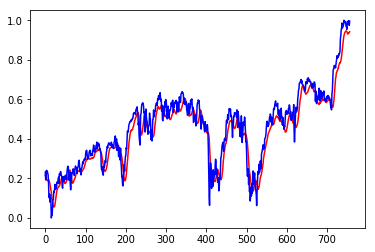

In [33]:
plt.plot(y_pred, 'r-')
plt.plot(y_test, 'b-')
plt.show()

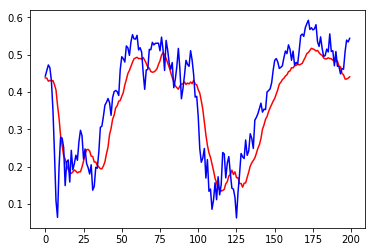

In [34]:
plt.plot(y_pred[400:600], 'r-')
plt.plot(y_test[400:600], 'b-')
plt.show()

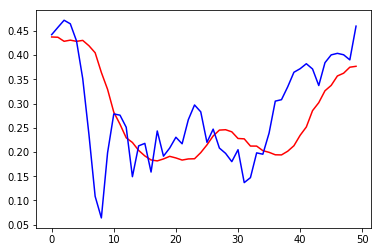

In [35]:
plt.plot(y_pred[400:450], 'r-')
plt.plot(y_test[400:450], 'b-')
plt.show()

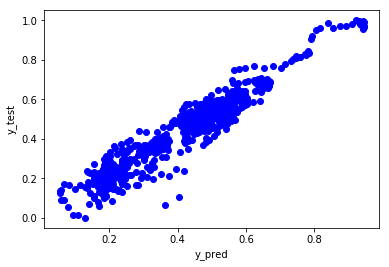

In [36]:
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()